In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [2]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.5,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))


In [3]:
data_name = "future_brr_v3"
data_path = "../processed_data/"+data_name+"/"

# Risk Measures
# Variance is automatically included
k_arr = [10,20] # Absolute risk aversion for exponential risk measure
q_arr_ES = [0.01,0.05,0.1] # Quantile level for expected shortfall

spot_name = "log return brr"
future_name = "log return future"

paras_results = []
likelihood_results = []
best_h_results = []

calibration_method = "MLE" # MM or MLE
q_arr = [0.05,0.1,0.9,0.95]

ls = os.listdir(data_path+'train/')
ls = [l for l in ls if l.endswith('.csv')]
for file in ls:
    # Calibration 
    train = pd.read_csv(data_path+'train/'+file)
    spot   = train.loc[:,spot_name]
    future = train.loc[:,future_name]
    u = ECDF(spot)(spot)
    v = ECDF(future)(future)
    
    kde_brr = KDE(spot, "Gaussian")
    kde_btc = KDE(future, "Gaussian")
    
    for C_name in Copulae:
        Copulae[C_name].Law_RS = kde_brr
        Copulae[C_name].Law_RF = kde_btc
    
    paras = []
    likelihood = []
    best_h = []
    for C_name in Copulae:
        if calibration_method == "MLE":
            Copulae[C_name].canonical_calibrate(u,v)
            
        elif calibration_method == "MM":
            Copulae[C_name].mm_calibrate(u,v,q_arr)

        print(C_name,'is done.\n')
    
    for C_name in Copulae:
        paras.append((C_name,Copulae[C_name].paras))
        
    for C_name in Copulae:
        ln = Copulae[C_name].dependency_likelihood(u,v)
        likelihood.append((C_name,ln))
        
    paras_results.append(paras)
    likelihood_results.append(likelihood)
    
    # Get Best h
    best_h = []
    for C_name in Copulae:
        best_h.append(optimize_h(Copulae[C_name], k_arr, q_arr_ES))
    best_h = pd.DataFrame(best_h)
    best_h.columns = ['Var'] + ['ERM k=%i'%k for k in k_arr] +  ['ES q=%.2f'%q for q in q_arr_ES]
    best_h.index = Copulae_names 
    best_h_results.append(best_h)
    
#     # Testing
#     test = pd.read_csv(data_path+'test/'+file)
#     spot_test   = train.loc[:,spot_name]
#     future_test = train.loc[:,future_name]

Optimization terminated successfully.
         Current function value: -0.425856
         Iterations: 34
         Function evaluations: 72
Gaussian is done.

Optimization terminated successfully.
         Current function value: -0.470180
         Iterations: 101
         Function evaluations: 214
t_Copula is done.

Optimization terminated successfully.
         Current function value: -0.468192
         Iterations: 157
         Function evaluations: 300
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.407092
         Iterations: 42
         Function evaluations: 93
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.419158
         Iterations: 46
         Function evaluations: 99
Frank is done.

Optimization terminated successfully.
         Current function value: -0.406259
         Iterations: 36
         Function evaluations: 78
Gumbel is done.

Optimization terminated successfully.
         

Optimization terminated successfully.
         Current function value: -0.427170
         Iterations: 86
         Function evaluations: 169
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.370792
         Iterations: 33
         Function evaluations: 71
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.385088
         Iterations: 34
         Function evaluations: 73
Frank is done.

Optimization terminated successfully.
         Current function value: -0.362979
         Iterations: 32
         Function evaluations: 70
Gumbel is done.

Optimization terminated successfully.
         Current function value: -0.426397
         Iterations: 36
         Function evaluations: 81
Plackett is done.

Optimization terminated successfully.
         Current function value: -0.427504
         Iterations: 72
         Function evaluations: 147
Gauss Mix Indep is done.

Optimization terminated successfully.
    

Optimization terminated successfully.
         Current function value: -0.478617
         Iterations: 68
         Function evaluations: 143
Gauss Mix Indep is done.

Optimization terminated successfully.
         Current function value: 0.000821
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.045157
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.062288
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.012758
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.002349
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000651
         Iterations: 16
         Function evaluations: 35
Optimi

Optimization terminated successfully.
         Current function value: 0.041362
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.057361
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.011187
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.001117
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: -0.000183
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.001136
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.050819
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.000946
         Iterations: 18
         Function evaluations: 39
Optimization terminated successfully.
         Current function value: -0.002036
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.001376
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.057847
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.083297
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.015007
         Iterations: 12
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.003616
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.050964
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.073733
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.012536
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.002023
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: -0.001188
         Iterations: 17
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000526
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.034366
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.002491
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000668
         Iterations: 17
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 0.000542
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.037029
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.051641
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.009100
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000525
         Iterations: 16
         Function evaluations: 33
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.034201
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.048247
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.007927
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -0.001137
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.002795
         Iterations: 16
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000711
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.037307
         Iterations: 15
         Function evaluations: 30
Optimization terminated successf

Optimization terminated successfully.
         Current function value: 0.002559
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.000075
         Iterations: 13
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000872
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.042564
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.052536
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.014872
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.004169
         Iterations: 11
         Function evaluations: 25
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.038504
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.048321
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.012225
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.003318
         Iterations: 13
         Function evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000201
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000835
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.047035
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.004258
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.001397
         Iterations: 11
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 0.001014
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.048399
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.066073
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.012457
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.003868
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.048486
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.065099
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.012959
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.004389
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.001685
         Iterations: 13
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000698
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.044073
         Iterations: 13
         Function evaluations: 26
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.003426
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000061
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000659
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.039255
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.053326
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.010274
         Iterations: 15
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000850
         Iterations: 15
         Function evaluations: 31
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.045348
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.060868
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.012635
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.002502
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000212
         Iterations: 17
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.000861
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.044851
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.003154
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000148
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.000993
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.048420
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.066043
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.012602
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.004672
         Iterations: 15
         Function evaluations: 33
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.045146
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.061780
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.011318
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.003838
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.001041
         Iterations: 17
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.001068
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.049616
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.004551
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.001124
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.001337
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.053371
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.072482
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.014213
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.005275
         Iterations: 15
         Function evaluations: 32
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.047497
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.064422
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.012835
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.003621
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.000074
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: -0.407042
         Iterations: 31
         Function evaluations: 67
Gaussian is done.

Optimization terminated successfully.
         Current function value: -0.490921
         Iterations: 60
         Function evaluations: 137
t_Copula is

Optimization terminated successfully.
         Current function value: 0.004839
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.001114
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: -0.383775
         Iterations: 31
         Function evaluations: 66
Gaussian is done.

Optimization terminated successfully.
         Current function value: -0.464242
         Iterations: 64
         Function evaluations: 143
t_Copula is done.

Optimization terminated successfully.
         Current function value: -0.453055
         Iterations: 128
         Function evaluations: 257
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.333959
         Iterations: 34
         Function evaluations: 73
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.402138
  

Optimization terminated successfully.
         Current function value: -0.427504
         Iterations: 92
         Function evaluations: 183
t_Copula is done.

Optimization terminated successfully.
         Current function value: -0.413540
         Iterations: 125
         Function evaluations: 249
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: -0.289206
         Iterations: 34
         Function evaluations: 76
Clayton is done.

Optimization terminated successfully.
         Current function value: -0.348385
         Iterations: 37
         Function evaluations: 81
Frank is done.

Optimization terminated successfully.
         Current function value: -0.396657
         Iterations: 33
         Function evaluations: 73
Gumbel is done.

Optimization terminated successfully.
         Current function value: -0.410647
         Iterations: 39
         Function evaluations: 90
Plackett is done.

Optimization terminated successfully.
         C

Optimization terminated successfully.
         Current function value: -0.474950
         Iterations: 63
         Function evaluations: 134
Gauss Mix Indep is done.

Optimization terminated successfully.
         Current function value: 0.000920
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.042135
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.054967
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.013360
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.002763
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: -0.000702
         Iterations: 15
         Function evaluations: 33
Optim

Optimization terminated successfully.
         Current function value: 0.051380
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.068490
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.016962
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 0.003628
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 17
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 0.001973
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.066540
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.003533
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: 0.000488
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.001386
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.056654
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.077707
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.017246
         Iterations: 14
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.005075
         Iterations: 15
         Function evaluations: 30
Optimization terminated successful

In [4]:
c_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(paras_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['paras']
    c_arr.append(c)
    
paras_results_pd = pd.concat(dict(zip(ls, c_arr)), axis=1)
paras_results_pd.columns = paras_results_pd.columns.droplevel(1)
paras_results_pd.index.name= None

l_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(likelihood_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['likelihood']
    l_arr.append(c)
    
likelihood_results_pd = pd.concat(dict(zip(ls, l_arr)), axis=1)
likelihood_results_pd.columns = likelihood_results_pd.columns.droplevel(1)
likelihood_results_pd.index.name= None

In [5]:
paras_results_pd

,0.csv,1.csv,10.csv,11.csv,12.csv,13.csv,14.csv,15.csv,16.csv,17.csv,...,21.csv,22.csv,23.csv,3.csv,4.csv,5.csv,6.csv,7.csv,8.csv,9.csv
Gaussian,{'rho': 0.8342232350874228},{'rho': 0.8232489222192871},{'rho': 0.7576081357645961},{'rho': 0.7439401027250618},{'rho': 0.7394047691821094},{'rho': 0.7223078227818345},{'rho': 0.7375031464662589},{'rho': 0.7302611060457019},{'rho': 0.7305998417212932},{'rho': 0.7476807343066245},...,{'rho': 0.7386496964156085},{'rho': 0.7605905767009232},{'rho': 0.7491536652187782},{'rho': 0.8012509602067681},{'rho': 0.7830018827691214},{'rho': 0.7719732030455634},{'rho': 0.7673616448044779},{'rho': 0.7378283646833912},{'rho': 0.7709344730275347},{'rho': 0.7652480126092989}
t_Copula,"{'rho': 0.8311181228592006, 'nu': 2.3196289211...","{'rho': 0.8265993079045046, 'nu': 2.2618707362...","{'rho': 0.772875976154657, 'nu': 2.01101925482...","{'rho': 0.7688778629033066, 'nu': 2.1381696517...","{'rho': 0.7684574740153921, 'nu': 2.0000000000...","{'rho': 0.7348275422347832, 'nu': 2.0000000000...","{'rho': 0.752085481967727, 'nu': 2.00000000000...","{'rho': 0.7603491416286946, 'nu': 2.0000000000...","{'rho': 0.779797030526113, 'nu': 2.00000000000...","{'rho': 0.8003675175038892, 'nu': 2.0000000000...",...,"{'rho': 0.7657016069026827, 'nu': 2.0000000000...","{'rho': 0.7845351694423393, 'nu': 2.0000000000...","{'rho': 0.751488367813162, 'nu': 2.07571527471...","{'rho': 0.8008266062177378, 'nu': 2.5883365949...","{'rho': 0.7924781797114405, 'nu': 2.4834084397...","{'rho': 0.7815257647740521, 'nu': 2.7065473129...","{'rho': 0.7749880325103798, 'nu': 2.9073463752...","{'rho': 0.7554444274789913, 'nu': 2.6243232926...","{'rho': 0.7854497268705899, 'nu': 2.6034998926...","{'rho': 0.7803898392825981, 'nu': 2.0796163143..."
t_Copula_Capped,"{'rho': 0.847119843573855, 'nu': 4.00000000000...","{'rho': 0.847119843573855, 'nu': 4.00000000000...","{'rho': 0.7947896167756703, 'nu': 4.0000000000...","{'rho': 0.7947896167756703, 'nu': 4.0000000000...","{'rho': 0.7862511457749007, 'nu': 4.0000000000...","{'rho': 0.7550501359368869, 'nu': 4.0000000000...","{'rho': 0.7709051620769137, 'nu': 4.0000000000...","{'rho': 0.7709051620769137, 'nu': 4.0000000000...","{'rho': 0.7904798817192773, 'nu': 4.0000000000...","{'rho': 0.8114791179756987, 'nu': 4.0000000000...",...,"{'rho': 0.781634170839427, 'nu': 4.00000000000...","{'rho': 0.8006634149446568, 'nu': 4.0000000000...","{'rho': 0.7746110109706735, 'nu': 4.0000000000...","{'rho': 0.8143805068166335, 'nu': 4.0000000000...","{'rho': 0.8067808034036713, 'nu': 4.0000000000...","{'rho': 0.7927614878602576, 'nu': 4.0000000000...","{'rho': 0.7839437196136223, 'nu': 4.0000000000...","{'rho': 0.7670892416150399, 'nu': 4.0000000000...","{'rho': 0.800611070019506, 'nu': 4.00000000000...","{'rho': 0.800611070019506, 'nu': 4.00000000000..."
Clayton,{'theta': 2.67180260937908},{'theta': 2.3934059401300027},{'theta': 1.896004520404961},{'theta': 1.7068040583508555},{'theta': 1.645088315110409},{'theta': 1.5059646086085683},{'theta': 1.5483427028638121},{'theta': 1.5359321511339459},{'theta': 1.541378127785398},{'theta': 1.7780989765111055},...,{'theta': 1.9620192503789882},{'theta': 2.1329901645157396},{'theta': 1.9231864936548742},{'theta': 2.2493260985323658},{'theta': 2.3098312076269756},{'theta': 2.0603628116078037},{'theta': 2.009227600097664},{'theta': 1.8740233310521217},{'theta': 2.0261854856797354},{'theta': 1.9390586443935003}
Frank,{'theta': 8.633262833104585},{'theta': 8.492217816959664},{'theta': 7.172345045455708},{'theta': 7.121151130598799},{'theta': 7.059751325252587},{'theta': 6.371482607877436},{'theta': 6.723875779440794},{'theta': 6.673989365613899},{'theta': 6.8103901452818985},{'theta': 7.180280944130839},...,{'theta': 6.453769661771629},{'theta': 6.926624452790707},{'theta': 6.641118234003838},{'theta': 7.625698495584945},{'theta': 7.56001876885397},{'theta': 7.286562866470871},{'theta': 7.132124176025416},{'theta': 6.774966219903967},{'theta': 7.464858188118671},{'theta': 7

In [6]:
likelihood_results_pd

,0.csv,1.csv,10.csv,11.csv,12.csv,13.csv,14.csv,15.csv,16.csv,17.csv,...,21.csv,22.csv,23.csv,3.csv,4.csv,5.csv,6.csv,7.csv,8.csv,9.csv
Gaussian,0.595498,0.567122,0.424306,0.402113,0.394350,0.368464,0.390892,0.379347,0.387387,0.415090,...,0.400458,0.437603,0.417644,0.461932,0.472591,0.449524,0.439427,0.390134,0.447862,0.437106
t_Copula,0.640920,0.630528,0.493562,0.468582,0.469227,0.431778,0.450771,0.457691,0.514475,0.561560,...,0.494622,0.545291,0.486086,0.537140,0.520827,0.487089,0.469239,0.430510,0.496285,0.504535
t_Copula_Capped,0.639535,0.627257,0.485837,0.462202,0.459846,0.423845,0.444434,0.443712,0.483399,0.526285,...,0.471751,0.518299,0.474791,0.534773,0.519491,0.487050,0.469886,0.430021,0.494886,0.497926
Clayton,0.556025,0.496287,0.379551,0.333954,0.319768,0.289202,0.299549,0.292403,0.291003,0.343353,...,0.383191,0.419533,0.382844,0.466942,0.478879,0.421347,0.407086,0.370786,0.409901,0.389701
Frank,0.532830,0.519399,0.408460,0.402122,0.394698,0.348370,0.375250,0.367165,0.370927,0.397239,...,0.354631,0.392168,0.375954,0.453387,0.449584,0.429722,0.419142,0.385072,0.436669,0.422129
Gumbel,0.565119,0.572085,0.429469,0.419431,0.421819,0.396657,0.420430,0.417641,0.469016,0.491167,...,0.409510,0.456559,0.423546,0.454228,0.435005,0.420707,0.406259,0.362979,0.429851,0.441533
Plackett,0.592233,0.581063,0.474608,0.467222,0.467551,0.410647,0.440398,0.446105,0.471949,0.512306,...,0.438812,0.477379,0.436202,0.501544,0.494599,0.468415,0.453257,0.426397,0.486122,0.485110
Gauss Mix Indep,0.629458,0.621200,0.491273,0.470476,0.474950,0.428357,0.450440,0.469019,0.533633,0.576269,...,0.497786,0.538427,0.473289,0.530747,0.511848,0.478617,0.460797,0.427504,0.491632,0.499361


In [7]:
best_h_results_pd = pd.concat(dict(zip(ls, best_h_results)), axis=1)

In [8]:
def cap(h):
    if h < 0:
        return 0
    elif h >1:
        return 1
    else:
        return h

In [9]:
columns = best_h_results_pd.columns
for c in columns:
     best_h_results_pd.loc[:,c] = best_h_results_pd.loc[:,c].apply(cap)

In [10]:
def hedging_effectiveness(h_arr, spot, future, k_arr, q_arr):
    results = np.ones((len(h_arr),1+len(k_arr)+len(q_arr)))
    for i, h in enumerate(h_arr):
        rh = spot-h*future
        results[i,:]=1-risk_measures(k_arr, q_arr, rh)/risk_measures(k_arr, q_arr, spot)
    return np.array([results[i,i] for i in range(len(h_arr))])

In [11]:
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)

In [12]:
display_likelihood = likelihood_results_pd.copy()
display_likelihood.columns = date_range_arr
display_likelihood = display_likelihood.reindex(sorted(display_likelihood.columns), axis=1)

In [13]:
display_paras = paras_results_pd.copy()
display_paras.columns = date_range_arr
display_paras = display_paras.reindex(sorted(display_paras.columns), axis=1)

In [14]:
display_best_h = best_h_results_pd.copy()
display_best_h.columns.set_levels(date_range_arr, level=0, inplace=True)
display_best_h = display_best_h.reindex(sorted(display_best_h.columns), axis=1)

In [15]:
if os.path.exists("../results/" + data_name)==False:
    print("Create new folder for results")
    os.mkdir("../results/" + data_name)
    os.mkdir("../results/" + data_name +"/MLE")
    os.mkdir("../results/" + data_name +"/MM")
    
if calibration_method == "MLE":
    path = "../results/"+ data_name +"/MLE/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

    
elif calibration_method == "MM":
    path = "../results/"+ data_name +"/MM/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

Create new folder for results


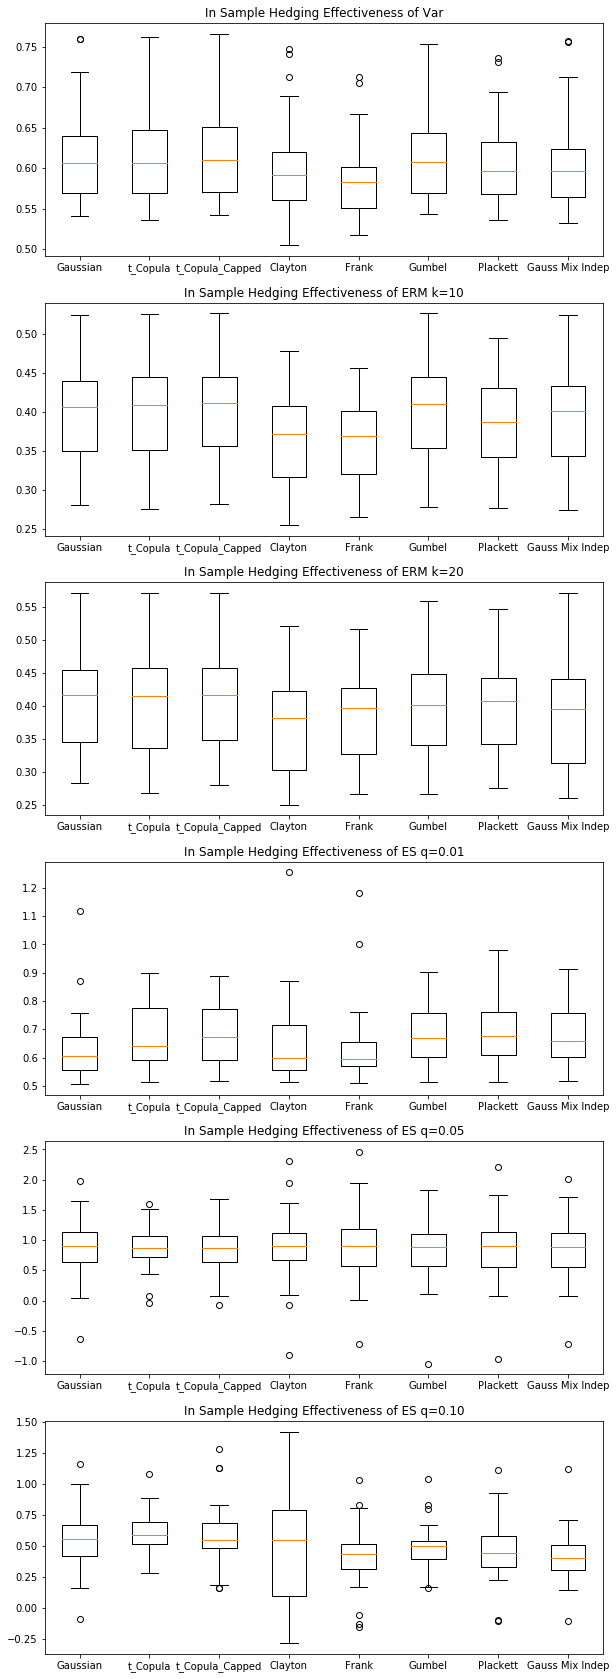

In [16]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'train/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("In Sample Hedging Effectiveness of %s"%name)
    
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"In Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"In Sample Hedging Effectiveness.png", transparent=True)

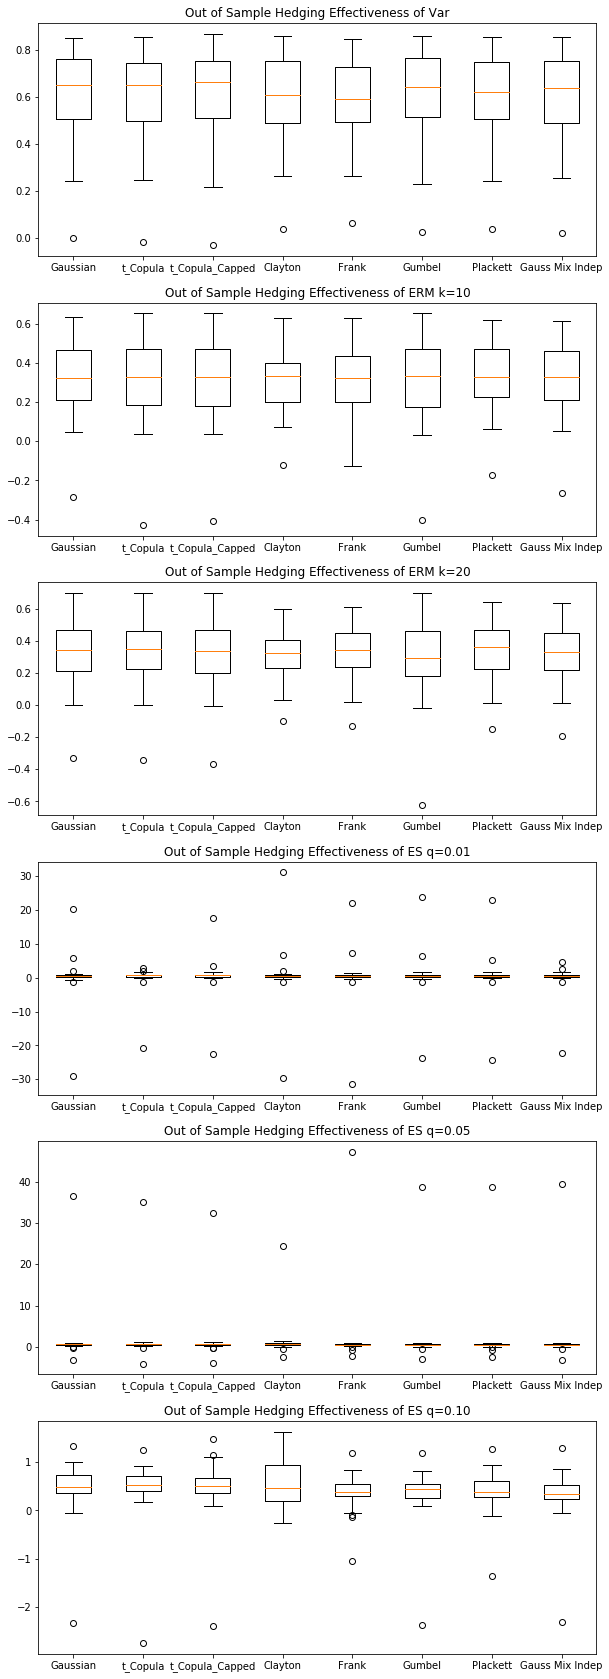

In [17]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'test/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
#     ax[i].set_xticks(np.linspace(1,len(Copulae_names)))
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("Out of Sample Hedging Effectiveness of %s"%name)
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"Out of Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"Out of Sample Hedging Effectiveness.png", transparent=True)